In [17]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LogisticRegression
import numpy as np

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as met

import graphviz 
from sklearn import tree

# Introduction

## Report and Problem Introduction

This report documents the analysis and modelling of the Titanic dataset from a Kaggle competition in attempt to predict survival. The titanic dataset stores 11 attributes about the passengers of the ocean linear from the aforementioned survival, age, sex, etc. During this analysis, the dataset will be summarise using exploratory techinques and then modelled with machine learning methods. The methods will be compared using their accuracy and other relevent features and will be used to observe the general traits that effect survival. 

In [2]:
# Data Loading

# load using pandas to get pandas dfs
trainDf = pd.read_csv('train.csv')
testDf = pd.read_csv('test.csv')

# Data Cleaning Functions

# Drops unrequired fields (id, ticket, cabin and name)
def dropFields(df):
    df = df.drop('PassengerId', axis=1)
    df = df.drop('Ticket', axis=1)
    df = df.drop('Cabin', axis=1)
    df = df.drop('Name', axis=1)
    return(df)

# replaces a given NA ages with averages
def fixNaAges(df, sex):
    # find Df for chosen Sex and record average age
    sexDf = df[df.Sex == sex] 
    avgSexAge = int(round(sexDf.Age.mean()))
    
    # Update Age NAs with the calculated average 
    sexDf.fillna({'Age':avgSexAge}, inplace = True)
    
    # copy updated Df for chosen sex to df and return
    df[df.Sex == sex] = sexDf
    return(df)

# prints counts for the two dfs
def printCounts(trainDf, testDf, caption):
    print("Train Counts: " + caption)
    print(trainDf.count())
    print("Test Counts: " + caption)
    print(testDf.count())
    
# Data cleaning

# Print inital counts 
printCounts(trainDf, testDf, "Initial")

# Drop Fields
cTrainDf = dropFields(trainDf)
cTestDf = dropFields(testDf)
printCounts(cTrainDf, cTestDf, "After dropping fields")

# Fix age NAs with sex average ages
cTrainDf = fixNaAges(cTrainDf, "male")
cTrainDf = fixNaAges(cTrainDf, "female")
cTestDf = fixNaAges(cTestDf, "male")
cTestDf = fixNaAges(cTestDf, "female")
printCounts(cTrainDf, cTestDf, "After fixing Age NAs")

# Drop any left NAs (a few from embarkment and fare)
cTestDf = cTestDf.dropna(axis = 0)
cTrainDf = cTrainDf.dropna(axis = 0)
printCounts(cTrainDf, cTestDf, "After dropping rows with NAs")

Train Counts: Initial
PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64
Test Counts: Initial
PassengerId    418
Survived       418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64
Train Counts: After dropping fields
Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Embarked    889
dtype: int64
Test Counts: After dropping fields
Survived    418
Pclass      418
Sex         418
Age         332
SibSp       418
Parch       418
Fare        417
Embarked    418
dtype: int64
Train Counts: After fixing Age NAs
Survived    891
Pclass      891
Sex         891
Age         891
SibSp       891
Parch  

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## Dataset and Cleaning

Basic data cleaning was done with the assistance of the Pandas library functions (used for the data frames). In the data cleaning process, fields with a lot of null values (cabin) and values that are difficult to model (e.g. names, ids and tickets) are removed. Also, null values in the age fields are updated by using the averages of the age for each sex, this is done instead of dropping them to avoid losing other patterns in rows while maintaining the average ages. Lastly, rows with nulls in the fare field (1 in the test data) and embarked (2 in the training data) are removed, no attempt was made to replace them because the small number of removed fields will not have an sizable impact on the data.

## Graphical Summaries and Transformations

In [3]:
# Combine both data sets for summaries 
df = pd.concat([cTestDf, cTrainDf], sort = False)

### Categorical Data (Freqency Bar Plots)

Text(0.5,1,'Sex')

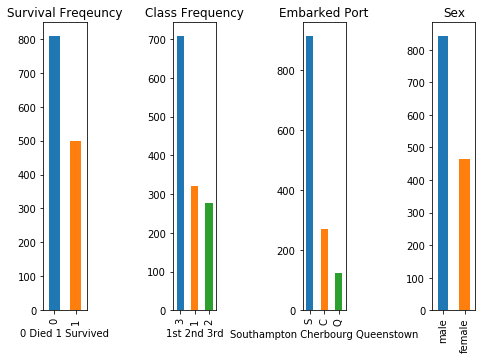

In [4]:
# Adjust subplot margins
plt.subplots_adjust(left=1, bottom=1, right=2, top=2, wspace=2, hspace=2)

# plot survial bar
plt.subplot(1, 4, 1)
df['Survived'].value_counts().plot(kind='bar')
plt.title('Survival Freqeuncy')
plt.xlabel('0 Died 1 Survived')

# plot passanger class bar
plt.subplot(1, 4, 2)
df['Pclass'].value_counts().plot(kind='bar')
plt.title('Class Frequency')
plt.xlabel('1st 2nd 3rd')

# plot port of embarkment bar
plt.subplot(1, 4, 3)
df['Embarked'].value_counts().plot(kind='bar')
plt.title('Embarked Port')
plt.xlabel('Southampton Cherbourg Queenstown')

# plot sex bar
plt.subplot(1, 4, 4)
df['Sex'].value_counts().plot(kind='bar')
plt.title('Sex')

The follwing can be observed:
* The majority of the passengers in the data did not seem to survive the accident according to the test and training data. 
* While the majority of passengers came as 3rd class, more 1st class passengers attended than 2nd class
* THe absolute majority of passengers came from the Cherbourg port compared to the other two (more than double Queenstown).
* Significantly more males were in the ship the females (nearly double)

### Numerical Data (Box Plots)

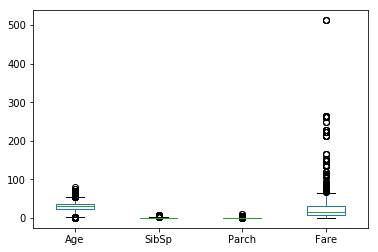

In [5]:
# plot a box plot of numeric fields only
boxDf = df[['Age','SibSp','Parch','Fare']]
boxDf.plot(kind='box')

The box plot of non categorical fields shows an issue with the scale variance between the different values. This scale difference makes it difficult to compare the data spread and location between different variables. Hence, scaling is necesarry. 

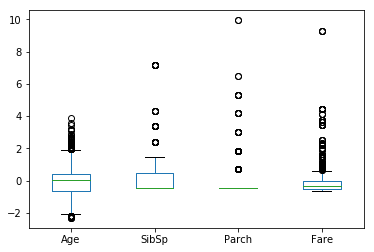

In [6]:
# scale the data using a mapper
mapper = DataFrameMapper([(boxDf.columns, pre.StandardScaler())])
scaledFeatures = mapper.fit_transform(boxDf.copy(), len(boxDf.columns))
sBoxDf = pd.DataFrame(scaledFeatures, index=boxDf.index, columns=boxDf.columns)

sBoxDf.plot(kind='Box')

Looking at the data we can see that:
* Fare data is tightly clustered with a lot of outliers. This probably because the majority of fares are clustered together and the more luxrious fares are unpopular or too expensive 
* Age distribution seems to fairly well spread out, but with a couple of outliers at the highest ages.
* Number of parents or children abroad seems to average around 0 in the scale with little to no range, meaning that the average is very low and very common. The outliers for the high values suggests not many family came to the trip.
* The number of sibilings or spouses seems to have a similar average than parents or children, but higher ranges and fewer outliers suggests that sibilings/spouses number above the average are more common than families above the average.

# Methods

In [7]:
# Change categorical fields with strings to ints 
# for fitting

cTestDf['Sex'] = cTestDf['Sex'].replace(['female'],0)
cTestDf['Sex'] = cTestDf['Sex'].replace(['male'],1)

cTrainDf['Sex'] = cTrainDf['Sex'].replace(['female'],0)
cTrainDf['Sex'] = cTrainDf['Sex'].replace(['male'],1)

# Add new binary variables for 2 value embarked 
cTestDf['EmbarkedS'] = cTestDf['Embarked']
cTestDf['EmbarkedS'] = cTestDf['EmbarkedS'].replace(['S'],1)
cTestDf['EmbarkedS'] = cTestDf['EmbarkedS'].replace(['Q'],0)
cTestDf['EmbarkedS'] = cTestDf['EmbarkedS'].replace(['C'],0)

cTestDf['EmbarkedQ'] = cTestDf['Embarked']
cTestDf['EmbarkedQ'] = cTestDf['EmbarkedQ'].replace(['S'],0)
cTestDf['EmbarkedQ'] = cTestDf['EmbarkedQ'].replace(['Q'],1)
cTestDf['EmbarkedQ'] = cTestDf['EmbarkedQ'].replace(['C'],0)

#cTestDf['EmbarkedC'] = cTestDf['Embarked']
#cTestDf['EmbarkedC'] = cTestDf['EmbarkedC'].replace(['S'],0)
#cTestDf['EmbarkedC'] = cTestDf['EmbarkedC'].replace(['Q'],0)
#cTestDf['EmbarkedC'] = cTestDf['EmbarkedC'].replace(['C'],1)


cTrainDf['EmbarkedS'] = cTrainDf['Embarked']
cTrainDf['EmbarkedS'] = cTrainDf['EmbarkedS'].replace(['S'],1)
cTrainDf['EmbarkedS'] = cTrainDf['EmbarkedS'].replace(['Q'],0)
cTrainDf['EmbarkedS'] = cTrainDf['EmbarkedS'].replace(['C'],0)

cTrainDf['EmbarkedQ'] = cTrainDf['Embarked']
cTrainDf['EmbarkedQ'] = cTrainDf['EmbarkedQ'].replace(['S'],0)
cTrainDf['EmbarkedQ'] = cTrainDf['EmbarkedQ'].replace(['Q'],1)
cTrainDf['EmbarkedQ'] = cTrainDf['EmbarkedQ'].replace(['C'],0)

#cTrainDf['EmbarkedC'] = cTrainDf['Embarked']
#cTrainDf['EmbarkedC'] = cTrainDf['EmbarkedC'].replace(['S'],0)
#cTrainDf['EmbarkedC'] = cTrainDf['EmbarkedC'].replace(['Q'],0)
#cTrainDf['EmbarkedC'] = cTrainDf['EmbarkedC'].replace(['C'],1)

cTrainDf = cTrainDf.drop(columns=['Embarked']) # drop original, no longer needed
cTestDf = cTestDf.drop(columns=['Embarked']) # drop original, no longer needed

# separate predictors from response and scale predictors

testPred = cTestDf.loc[:, cTestDf.columns != 'Survived']
testRes = cTestDf['Survived']
trainPred = cTrainDf.loc[:, cTrainDf.columns != 'Survived']
trainRes = cTrainDf['Survived']

mapper = DataFrameMapper([(trainPred.columns, pre.StandardScaler())])
scaledFeatures = mapper.fit_transform(trainPred.copy(), len(trainPred.columns))
sTrainPred = pd.DataFrame(scaledFeatures, index=trainPred.index, columns=trainPred.columns)

mapper = DataFrameMapper([(testPred.columns, pre.StandardScaler())])
scaledFeatures = mapper.fit_transform(testPred.copy(), len(testPred.columns))
sTestPred = pd.DataFrame(scaledFeatures, index=testPred.index, columns=testPred.columns)

## print metrics (Accuracy, confusion, f1)
def printMetrics(prediction):
    print('accuracy', met.accuracy_score(testRes, prediction))
    print()
    print(met.confusion_matrix(testRes, prediction))
    print()
    print('f1', met.f1_score(testRes, prediction))

## Logistic Regression

Logistic Regression is a linear classification method. Logistic Regression is considered a supervised method because it takes in the data and predefined labels. 

To achieve its classification, Logistic Regression fits a line to separate the data into classes. The line is fitted by minimising the Mean Square Error (error between line and points) by changing the coefficients assigned to variables and the intercept. To minimise the error a method called gradient descent is used which updates the parameters (coeffients and intercepts) through the use to their partial derviates to find a local minimum/maximum.

Logistic regression finds the label by using a transformation function (e.g. sigmoid) to decide whether the points are in a particular class or not based on the value of the function.

In [8]:
# Fit and prediction
clf = LogisticRegression().fit(sTrainPred, trainRes)
prediction = clf.predict(sTestPred)

### Coefficents Interpretation

In [9]:
# create table for coefs
coefs = pd.concat([pd.DataFrame(trainPred.columns),
                 pd.DataFrame(np.transpose(clf.coef_))],
                axis = 1)
coefs.loc[len(coefs)] = ['intercept', clf.intercept_[0]]
print(coefs) # print table

           0         0
0     Pclass -0.904127
1        Sex -1.272542
2        Age -0.515014
3      SibSp -0.355794
4      Parch -0.072713
5       Fare  0.099337
6  EmbarkedS -0.185054
7  EmbarkedQ -0.013494
8  intercept -0.649258


The coefficient can help in interpreting the effects of predictors on the prediction/response. The following observations can be made:
* Sex (encoded with 0 female and 1 male) is the strongest predictor, and is negative suggesting females had a higher survival rate than the other sex.
* Embarked predictors had a weak effect generally, suggest the port of embarkment had little impact.
* Other variables that were strong were Pclass1 (positive), Pclass3 (negative) and Age (negative). Suggests that younger people from 1st class had higher survival rates than older people and people in 3rd class.
* Interstingly spouses seem to have lower survival according to this model (negative) compares to families which had a very small negative coefficent (possible little impact).

### Metrics

In [10]:
# Metrics (predtion vs Test response)
printMetrics(prediction)

accuracy 0.7697841726618705

[[216  43]
 [ 53 105]]

f1 0.6862745098039216


The model seems to have decent accuracy at 76.98 percent (correct to 2DP), but seems to mispredict more dead than mispredicting survival generally (which possibly led to a lower F1).

## Support Vector Machines

Support Vector Machines help improve logistic regression by selecting the line with the largest margin to separate the two classes. To do this, support vector machines add two lines (w ^ T + b) = 1 and (w ^ T + b) = -1  (where w is the vector of coefficients transposed and b is the intercept) to represent the margins. To find the maximum width, the line is varried (intercept and coefficent) to maximise (or minimise the inverse) the distances to the line but this time with the restriction thatt no points can be ahead of the margins of the line. To decide the points label, the sign of the function of the point is used. 

Support Vector Machines can have two types of margins:
* Hard: doesn't tolerate points outside of their margins (narrower)
* Soft: more tolerance for points outside their margins (wider)

The hardness of the margins is decided by variable C, which adds a penelty to the error of margins (larger C more penalty and harder).

To help interpreting non linear data, a kernel can be used to carry what is known as a "kernel trick", which essentially transforms the data to a higher dimension. There are various kernels that can be used, the most common is the Raidial Bias Function (RBF). RBF takes a gamma parameter which controls the variance or influence of the Support Vector Machine (the higher the gamma the lower the variance).

### Hyperparameter Parameter Tuning 

In [11]:
# Code adapted from https://github.com/yuguan1/example-ML-code

# Set the parameters by cross-validation  ['linear', 'rbf', 'sigmoid','poly'],

parameters = [{'kernel': ['rbf'],
                'gamma': [1e-4, 0.01, 0.1, 0.5],
                'C': [1, 10, 100, 1000]}]

# Tune parameters using 5 fold cross validation 

print("# Tuning hyper-parameters")
clf = GridSearchCV(SVC(), parameters, cv=5)
clf.fit(sTrainPred, trainRes)

print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

# Tuning hyper-parameters
best parameters:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
-------------------------------------
0.618 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.792 (+/-0.037) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.826 (+/-0.042) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.816 (+/-0.046) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.791 (+/-0.054) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.803 (+/-0.029) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.819 (+/-0.053) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.793 (+/-0.039) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.786 (+/-0.037) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.829 (+/-0.062) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.799 (+/-0.070) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.775 (+/-0.041) for {'C': 100, 'gamma': 0.5, 'kernel': 'rbf'}
0.787 (+/-0.039) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.820 (+/-0.046) for {'C': 1000, 'gamma': 0.01, 'kern

To find the ideal parameters for the Support Vector Machine (C and gamma as stated before), k fold cross validation using the training data was carried where k = 5. In k fold cross validation the data is randomly divided into k folds, one fold is used as test data and the rest as trainning data. This techinques will basically be used to train and test the model with different parameters with each set of parameters compared using accuracy (the pparameters with the highest accuracy is chosen as ideal).

The results with 5 fold cross validation showed that the ideal C is 100 (hard and narrow margins) and a gamma of 0.01 (relatively small variance). 

In [12]:
# Fit and predict using optimal params from cv
optimalC = 100
optimalGamma = 0.01
clf.fit(sTrainPred, trainRes)
prediction = clf.predict(sTestPred)

# Metrics (predtion vs Test response)

printMetrics(prediction)

accuracy 0.7793764988009593

[[224  35]
 [ 57 101]]

f1 0.6870748299319728


When the optimal values are selected (C = 100 and Gamma = 0.01) the accuracy of the Support Vector Machine model is slightly better than the logistic regression. However, the f1 score seems to have been slightly harmed as a result of this model picking even more mispredicted deaths than logistic regression, meaning that this model failed at fixing the main issue with the previous model.

## Decision Tree

In [30]:
parameters = [{'max_depth': [3,4,5,6,7,8,9,10]}]

# Tune parameters using 5 fold cross validation 

print("# Tuning hyper-parameters")
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
clf.fit(sTrainPred, trainRes)

print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

# Tuning hyper-parameters
best parameters:
{'max_depth': 6}
-------------------------------------
0.809 (+/-0.028) for {'max_depth': 3}
0.805 (+/-0.059) for {'max_depth': 4}
0.812 (+/-0.057) for {'max_depth': 5}
0.818 (+/-0.049) for {'max_depth': 6}
0.811 (+/-0.039) for {'max_depth': 7}
0.808 (+/-0.065) for {'max_depth': 8}
0.811 (+/-0.033) for {'max_depth': 9}
0.803 (+/-0.060) for {'max_depth': 10}


In [35]:
# fit and prediction
optimalDepth = 6

clf = DecisionTreeClassifier(max_depth = optimalDepth)
clf.fit(sTrainPred, trainRes)
prediction = clf.predict(sTestPred)

# Metrics (prediction vs Test response)

printMetrics(prediction)

accuracy 0.762589928057554

[[219  40]
 [ 59  99]]

f1 0.6666666666666667
0      0
1      1
2      1
3      1
4      0
5      0
6      0
7      0
8      1
9      1
10     1
11     1
12     0
13     0
14     0
15     1
16     0
17     1
18     0
19     1
20     0
21     1
22     1
23     1
24     0
25     1
26     0
27     0
28     1
29     0
      ..
861    0
862    1
863    0
864    0
865    1
866    1
867    0
868    0
869    1
870    0
871    1
872    0
873    0
874    1
875    1
876    0
877    0
878    0
879    1
880    1
881    0
882    0
883    0
884    0
885    0
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64


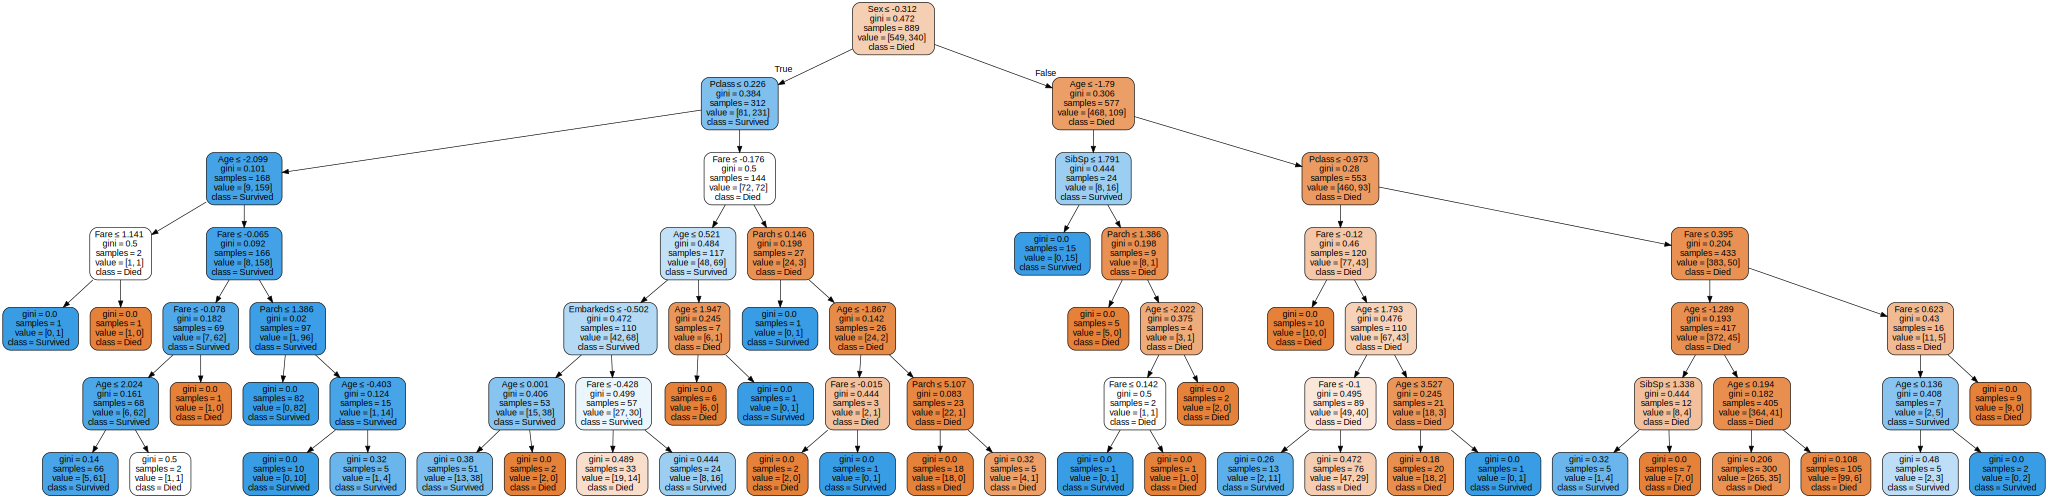

In [36]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("X") 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(sTrainPred.columns),  
                         class_names=['Died','Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
# RND = BAD +HYPERS

## Random Forest

In [ ]:
parameters = [{'max_depth': [3,4,5,6,7,8,9,10],
               'n_estimators': [10,20,40,100,200,300]}]

# Tune parameters using 5 fold cross validation 

print("# Tuning hyper-parameters")
clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
clf.fit(sTrainPred, trainRes)

print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [ ]:
# fit and prediction
optimalDepth = 10
optimalEstimators = 100
# max_depth=3, n_estimators=20, max_features=1
clf = RandomForestClassifier(max_depth = optimalDepth, n_estimators = optimalEstimators)
clf.fit(sTrainPred, trainRes)
prediction = clf.predict(sTestPred)

# Metrics (predtion vs Test response)

printMetrics(prediction)

# RND = BAD +HYPERS